In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from model.base_intensity import SineBaseIntensity

np.set_printoptions(precision=3)
%matplotlib inline
%load_ext autoreload
%autoreload 2

input_folder = "../data/working"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
social = pd.read_pickle("%s/MAINSTREAM_NEWS-bullying-1week.pkl" % input_folder).set_index('date')
news = pd.read_pickle("%s/MAINSTREAM_NEWS-bullying-1week.pkl" % input_folder).set_index('date')

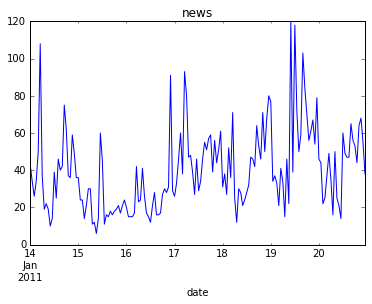

In [17]:
news.resample('H').size().plot(title='news')

In [18]:
social.resample('H').size().plot(title='social')

# Fitting base intensity shape with sin functions

x = [  7.957  13.839  39.937   2.769   3.029]
f = 58643.645476
x = [ 21.818   9.263  48.994   1.995   2.348]
f = 39968.8483099


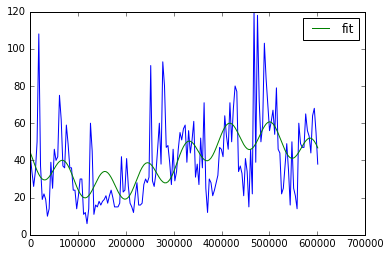

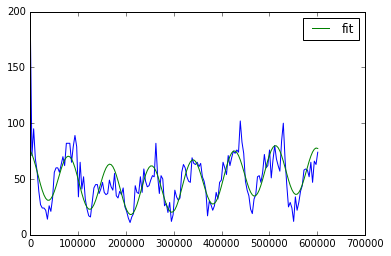

In [5]:
T1 = 3600. * 24
T2 = 3600. * 24 * 7
pi = np.pi

dfs = [news, social]

for df in dfs:
    
    h_counts = df.resample('H').size()
    t = (h_counts.index - h_counts.index[0]).total_seconds()
    y = h_counts.values    

    def f(x, t):
        A1, A2, A3, w1, w2 = x
        return A1 * np.sin(2 * pi / T1 * t + w1) + A2 * np.sin(2 * pi / T2 * t + w2) + A3

    def obj(x):    
        return np.square(f(x, t) - y).sum()
    
    def callback(xk):
        print xk


    best_fun = None
    best_x = None
    for i in range(10):
        w1, w2 = np.random.rand(2) * 2 * pi
        A3 = np.mean(y)
        A1, A2 = np.random.exponential(scale=np.std(y), size=2)
        x0 = [A1, A2, A3, w1, w2]
        method = 'TNC'
        bounds = [(0, None), (0, None), (0, None), (0, 2 * pi), (0, 2 * pi)]
        res = minimize(obj, x0, method=method, bounds=bounds)

        if best_fun is None or res.fun < best_fun:
            best_fun = res.fun
            best_x = res.x

    print "x =", best_x
    print "f =", best_fun

    plt.figure()
    plt.plot(t, y)
    plt.plot(t, f(best_x, t), label='fit')
    plt.legend()

# Fit with SineBaseIntensity

In [6]:
T1 = 3600. * 24
T2 = 3600. * 24 * 7

base_intensity = SineBaseIntensity(n_components=2, periods=np.array([T1, T2]))

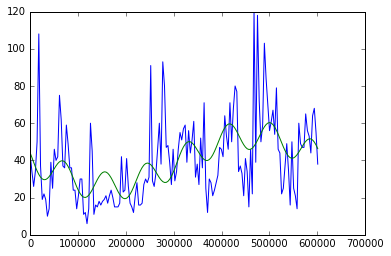

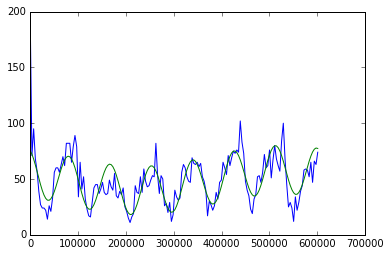

In [7]:
for df in dfs:
    
    h_counts = df.resample('H').size()
    t = (h_counts.index - h_counts.index[0]).total_seconds()
    y = h_counts.values    
    timestamps = (df.index - df.index[0]).total_seconds()
    base_intensity.init_params([(tt, None, None) for tt in timestamps], run_times=10, normalize=False)
    
    plt.figure()
    plt.plot(t, y, label='true')
    plt.plot(t, base_intensity.eval(t), label='fit')